# Analyze zebrafish dataset

#### Notebook for analyzing zebrafish perturb-seq datasets

## Library imports

In [1]:
import pandas as pd
import scanpy as sc
import scvelo as scv
import numpy as np
import scipy

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR,FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## Constants

In [36]:
DATASET = "zebrafish"

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## General setting

In [37]:
plt.rcParams['svg.fonttype'] = 'none'
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

## Loading dataset

In [38]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "seu_NC_clustered_normalized.h5ad")
ss3 = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
metadata = pd.read_csv(DATA_DIR / DATASET / "raw" / "metadata.csv",index_col = 0)

In [39]:
adata = adata[metadata.index.tolist()]

In [40]:
adata.obs = metadata

## Visualize via UMAP

In [41]:
# Using MELD to calculate sample-associated density estimates and relative likelihood
metadata = adata.obs
metadata['genotype_name'] = metadata['sgRNA_group']
metadata['genotype'] = metadata['sgRNA_group']
metadata['replicate'] = "A"
metadata

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,RNA_snn_res.1,seurat_clusters,sgRNA_group,DoubletFinder,proj,RNA_snn_res.0.8,cell_anno,latent_time_imputed,latent_time_imputed_scvi,term_state_imputed,cell_anno_old,genotype_name,genotype,replicate
p1_AAACGGGAGCTAGTTC-1,SeuratProject,9374.373090,3125,p1,0.601578,14,14,fli1a_erf_erfl3,Singlet,perturbseq,6,mNC_head_mesenchymal,0.599100,0.567514,NaN,mNC_head_mesenchymal,fli1a_erf_erfl3,fli1a_erf_erfl3,A
p1_AAACGGGCAAAGAATC-1,SeuratProject,16617.288939,3908,p1,0.752648,2,2,fli1a_erf_erfl3,Singlet,perturbseq,9,Pigment_gch2_high,0.761031,0.783371,NaN,Pigment,fli1a_erf_erfl3,fli1a_erf_erfl3,A
p1_AAACGGGCAATGTAAG-1,SeuratProject,10564.695306,3262,p1,0.888390,17,17,mitfa_tfec_inhouse,Singlet,perturbseq,4,mNC_hox34,0.364584,0.289242,NaN,unclassified2,mitfa_tfec_inhouse,mitfa_tfec_inhouse,A
p1_AAACGGGCAGCAGTTT-1,SeuratProject,17754.127675,3934,p1,0.579913,19,19,fli1a_erf_erfl3,Singlet,perturbseq,7,mNC_arch2,0.236565,0.428227,NaN,mNC_arch2,fli1a_erf_erfl3,fli1a_erf_erfl3,A
p1_AAACGGGGTAGCGTAG-1,SeuratProject,15028.838200,3638,p1,0.467387,6,6,fli1a_erf_erfl3,Singlet,perturbseq,5,unclassified1,0.268428,0.410988,NaN,unclassified1,fli1a_erf_erfl3,fli1a_erf_erfl3,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p11_TTTGCGCAGAGTAATC-1,SeuratProject,6202.170676,2499,p11,0.776390,8,8,ebf3a,Singlet,perturbseq,0,mNC_vagal,0.387833,0.428689,NaN,Pigment_sox6_high_vagel,ebf3a,ebf3a,A
p11_TTTGGTTTCAACTCTT-1,SeuratProject,3644.718485,1857,p11,1.794744,5,5,elf1,Singlet,perturbseq,6,mNC_head_mesenchymal,0.538755,0.549123,NaN,mNC_head_mesenchymal,elf1,elf1,A
p11_TTTGGTTTCCTATTCA-1,SeuratProject,8422.826902,3344,p11,0.510019,25,25,nr2f2,Singlet,perturbseq,5,mNC_arch1,0.412674,0.363753,NaN,mNC_arch1,nr2f2,nr2f2,A
p11_TTTGGTTTCTAACTCT-1,SeuratProject,6612.583387,2661,p11,0.449287,6,6,ebf3a,Singlet,perturbseq,15,unclassified1,0.259958,0.374038,NaN,unclassified1,ebf3a,ebf3a,A


In [42]:
## Update pigment cell annotation
adata.obs["cell_anno_new"] = adata.obs["cell_anno"].copy()
adata.obs["cell_anno_new"][adata.obs["cell_anno_new"] == "Pigment_gch2_high"] = "Pigment"

In [43]:
perturbseq = adata[adata.obs["sgRNA_group"].isin(["mitfa_tfec_inhouse","negative","control","mitfa","tfec","tfec_mitfa_bhlhe40","mitfa_tfec","mitfa_tfec_tfeb","elf1","nr2f2","nr2f5"])].copy()

highlight_cell_types = ['mNC_hox34', 'mNC_head_mesenchymal',"mNC_arch2","Pigment","Other"]  # replace with your cell types of interest

# Create a new column for colors
perturbseq.obs['highlight'] = perturbseq.obs['cell_anno_new'].copy()
palette = dict(zip(ss3.obs["cell_type"].cat.categories, ss3.uns['cell_type_colors']))
# Set cell types to grey if they are not in the highlight list
perturbseq.obs['highlight'] = perturbseq.obs['highlight'].apply(lambda x: x if x in highlight_cell_types else 'Other')

# Create a color map where 'Other' is grey
colors = ['grey' if ct == 'Other' else palette[ct] for i, ct in enumerate(highlight_cell_types)]
color_map = {ct: color for ct, color in zip(highlight_cell_types, colors)}
color_map['Other'] = 'grey'

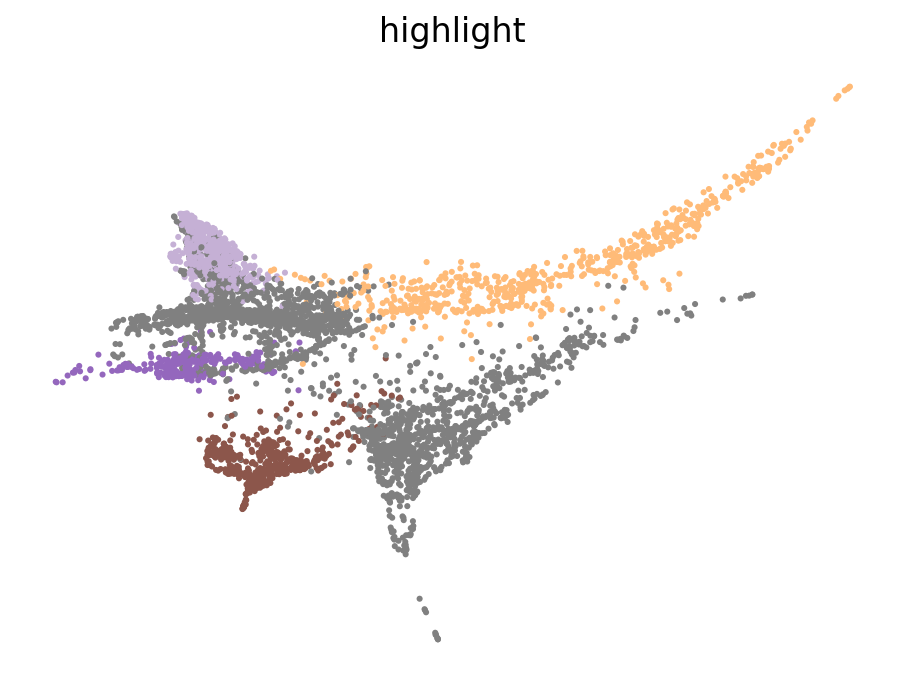

In [44]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize = (7,5))
    sc.pl.embedding(perturbseq, color='highlight',basis="phate",legend_loc = None, palette=color_map,frameon = False,size=30,ax = ax)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'INTRO_figure_perturb.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )
    plt.show()

## Visualize nr2f2, tfec, mitfa and elf1 perturbation effect

In [45]:
sgRNA_groups = ["nr2f2","tfec","mitfa","elf1"]

In [46]:
for group in sgRNA_groups:
    sample_likelihoods = pd.read_csv(DATA_DIR / DATASET / "raw" / f"likelihood_{group}.csv",index_col = 0)
    condition = (metadata['sgRNA_group'] == 'control') | (metadata['sgRNA_group'] == group)
    experimental_samples = [f'{group}A', f'{group}B']
    
    df = pd.DataFrame(sample_likelihoods[experimental_samples])
    df[group] = df.mean(1)
    # Calculate the percentiles values
    
    down = df[group].quantile(0.2)
    up = df[group].quantile(0.8)

    # Apply the condition to set values outside the 5th and 95th percentiles to NaN
    df['quantile_value'] = np.where((df[group] > up) | (df[group] < down), df[group], np.nan)
    df['quantile_value'] = df['quantile_value'] - np.mean(df[group])
    
    # Visualize the perturbation on terminal states
    cell_types = ['mNC_hox34', 'mNC_head_mesenchymal',"mNC_arch2","Pigment"]  # replace with your cell types of interest
    vec = adata[condition].obs['cell_anno_new'].apply(lambda x: 1 if x in cell_types else np.nan)
    df['quantile_value'] = np.array(df['quantile_value']) * np.array(vec)
    
    adata_sub = adata[condition].copy()
    adata_sub.obs[f"{group}_score"] = np.array(df['quantile_value']).copy()
    
    ## Plot the figure
    overall_score = pd.DataFrame({"score":np.array([np.nan]*adata_sub.shape[0])})
    overall_score.index = adata_sub.obs.index.tolist()
    overall_score.loc[adata_sub.obs.index.tolist(),"score"]= np.array(adata_sub.obs[f"{group}_score"])
    
    adata_sub.obs[f"{group}_score"] = np.array(overall_score["score"])
    adata_sub.obs['highlight'] = (~np.isnan(adata_sub.obs[f"{group}_score"])).astype(str)
    
    highlighted_points = adata_sub[adata_sub.obs['highlight'] == 'True']
    x_highlight = highlighted_points.obsm['X_phate'][:, 0]
    y_highlight = highlighted_points.obsm['X_phate'][:, 1]
    color_values = highlighted_points.obs[f'{group}_score']  # Adjust to your continuous variable
    
    with mplscience.style_context():  # Use the mplscience style context
    
        fig, ax = plt.subplots(figsize=(6,4))

        sc.pl.embedding(adata_sub,basis="phate",color = f"{group}_score",vcenter = 0,show=False,ax = ax)
        plt.scatter(
            x_highlight,
            y_highlight,
            c=color_values,
            cmap='viridis',  # Choose a gradient color map, e.g., 'viridis', 'plasma', 'inferno', etc.
            s=20,           # Larger size for highlighted points
            #edgecolor='black',  # Optional: border for emphasis
        )

        if SAVE_FIGURES:
            fig.savefig(
                    FIG_DIR / DATASET / f'{group}_perturbation.svg',
                    format='svg',
                    transparent=True,
                    bbox_inches='tight'
                )
        plt.show()

## Visualize differential expressed genes in tfec perturbation panel

In [47]:
perturbseq = adata.copy()
perturbseq = perturbseq[~perturbseq.obs['cell_anno_new'].isin(["unclassified2","unclassified1","Mutant_hox23","Mutant"]),]
seu_small = perturbseq[perturbseq.obs['sgRNA_group'].isin(['control', "tfec"]),]
genotype = seu_small.obs["sgRNA_group"].tolist()

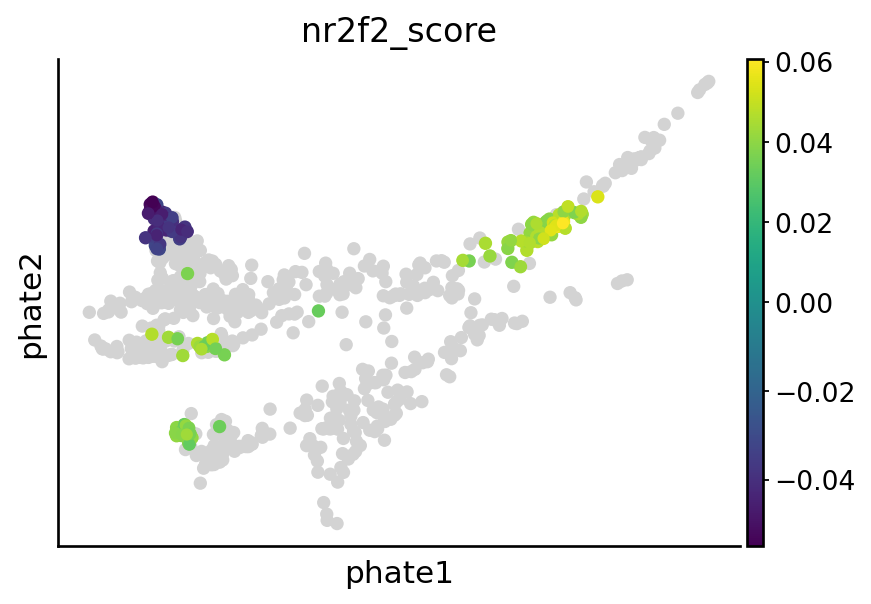

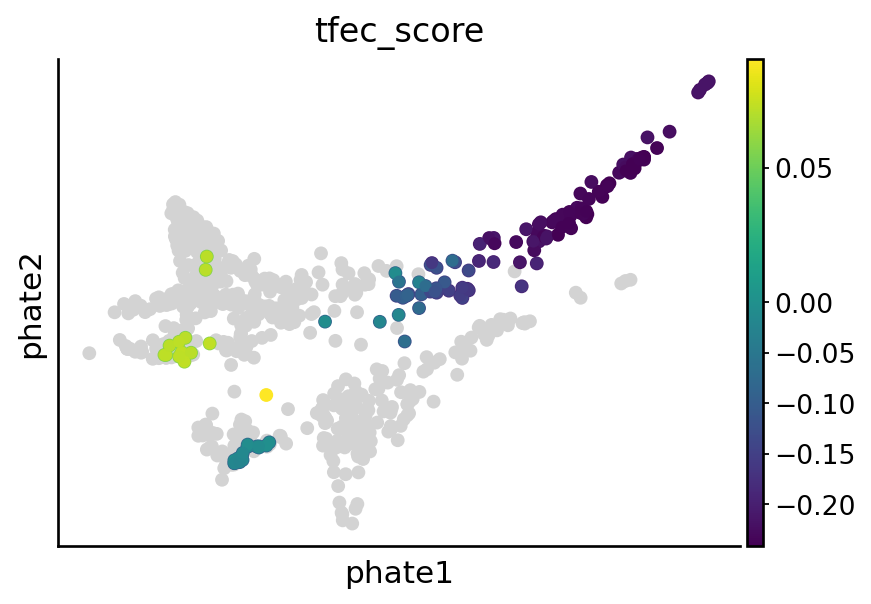

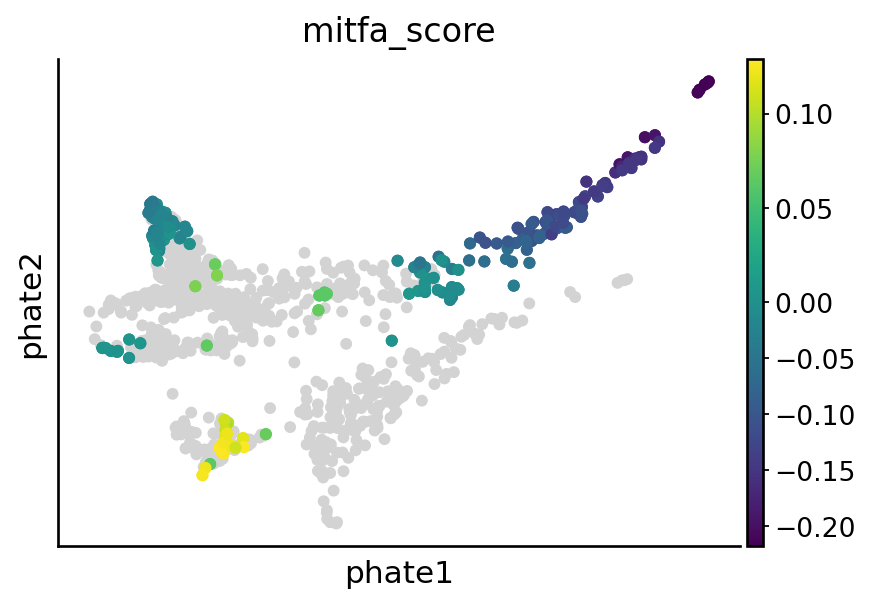

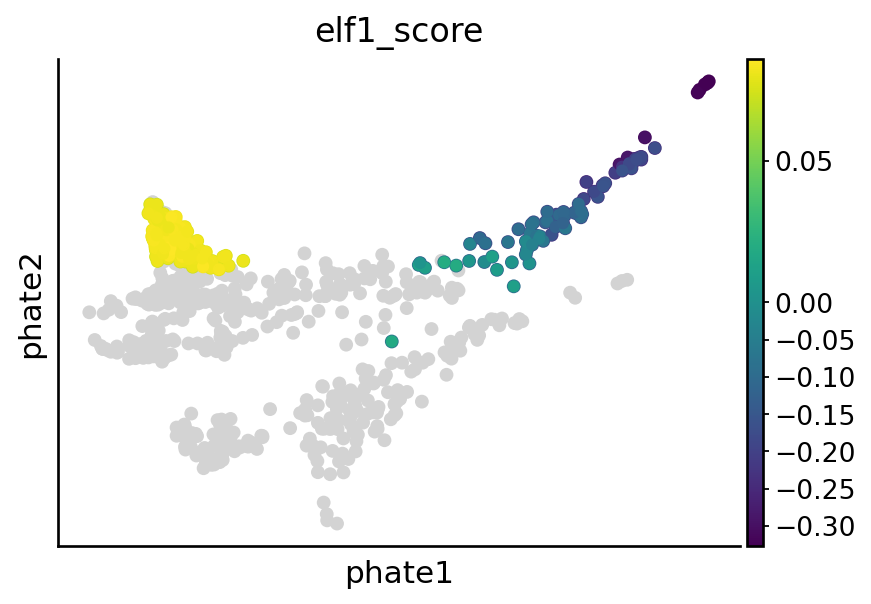

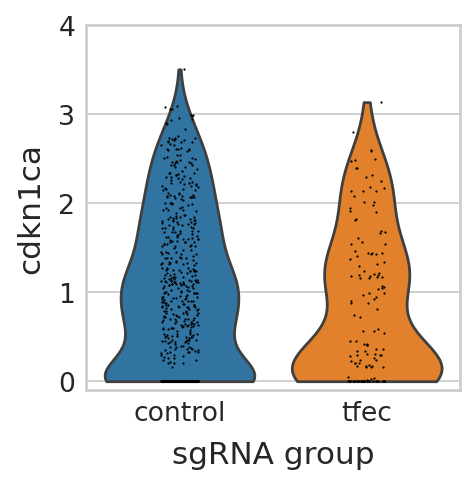

In [48]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['cdkn1ca'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    ax.set_ylim(bottom=-0.1,top=4)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'cdkn1ca.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

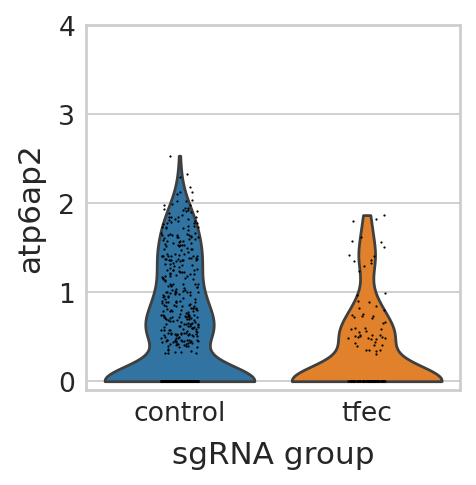

In [49]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['atp6ap2'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    ax.set_ylim(bottom=-0.1,top=4)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'atp6ap2.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

### test significance

In [50]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "tfec","cdkn1ca"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "tfec","cdkn1ca"].X.toarray().reshape(-1),equal_var = False,alternative = "less")

TtestResult(statistic=-2.0416193271649687, pvalue=0.021191380003823368, df=219.9875671451483)

In [51]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "tfec","atp6ap2"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "tfec","atp6ap2"].X.toarray().reshape(-1),equal_var = False,alternative = "less")

TtestResult(statistic=-5.547499181077916, pvalue=3.4438545499844835e-08, df=270.9981680245929)

## Visualize differential expressed genes in elf1 perturbation panel

In [52]:
perturbseq = adata.copy()
perturbseq = perturbseq[~perturbseq.obs['cell_anno_new'].isin(["unclassified2","unclassified1","Mutant_hox23","Mutant"]),]
seu_small = perturbseq[perturbseq.obs['sgRNA_group'].isin(['control', "elf1"]),]
genotype = seu_small.obs["sgRNA_group"].tolist()

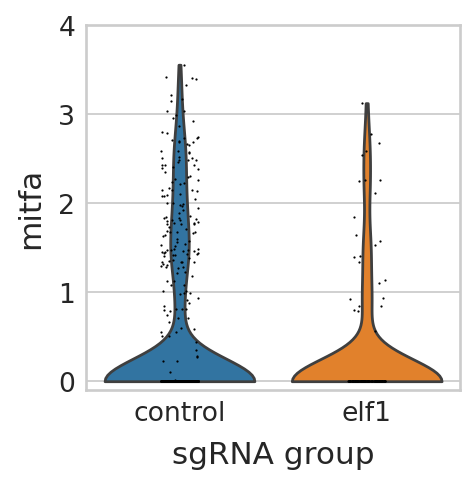

In [53]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['mitfa'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    ax.set_ylim(bottom=-0.1,top=4)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'mitfa_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

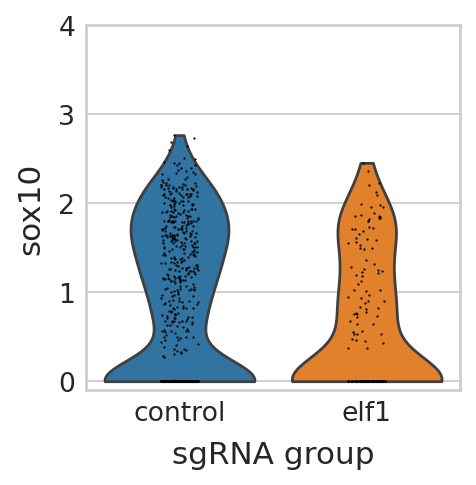

In [54]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['sox10'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    ax.set_ylim(bottom=-0.1,top=4)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'sox10_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

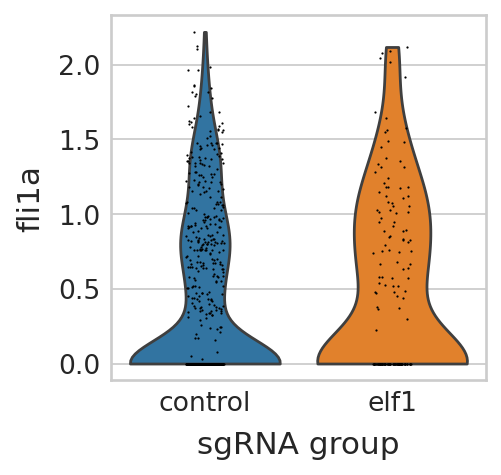

In [55]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['fli1a'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'fli1a_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

### test significance

In [56]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "elf1","mitfa"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "elf1","mitfa"].X.toarray().reshape(-1),equal_var = False,alternative = "less")

TtestResult(statistic=-3.429003795549063, pvalue=0.0003452279743702678, df=300.522449116822)

In [57]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "elf1","sox10"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "elf1","sox10"].X.toarray().reshape(-1),equal_var = False,alternative = "less")

TtestResult(statistic=-4.108995730134873, pvalue=2.6789127768845648e-05, df=255.2575590451451)

In [58]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "elf1","fli1a"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "elf1","fli1a"].X.toarray().reshape(-1),equal_var = False,alternative = "greater")

TtestResult(statistic=1.3860128076275413, pvalue=0.0835617324921002, df=223.63128948496157)

## Visualize differential expressed genes in pigment cell lineage of elf1 perturbation panel

In [83]:
perturbseq = adata.copy()
perturbseq = perturbseq[perturbseq.obs['cell_anno_new'].isin(["Pigment"]),]
seu_small = perturbseq[perturbseq.obs['sgRNA_group'].isin(['control', "elf1"]),]
genotype = seu_small.obs["sgRNA_group"].tolist()

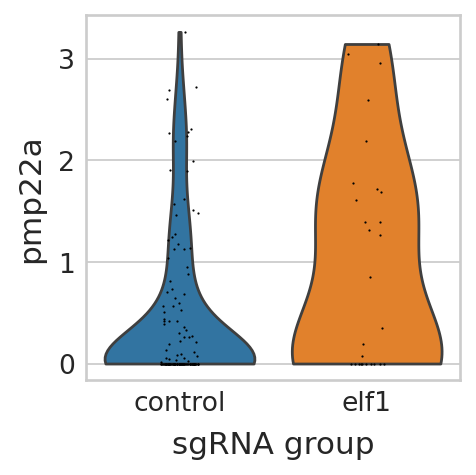

In [60]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['pmp22a'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'pmp22a_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

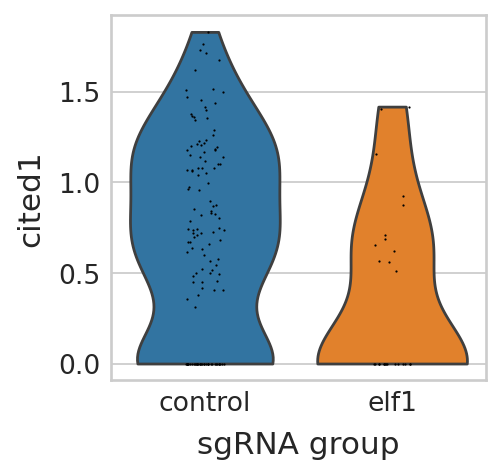

In [61]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['cited1'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'cited1_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

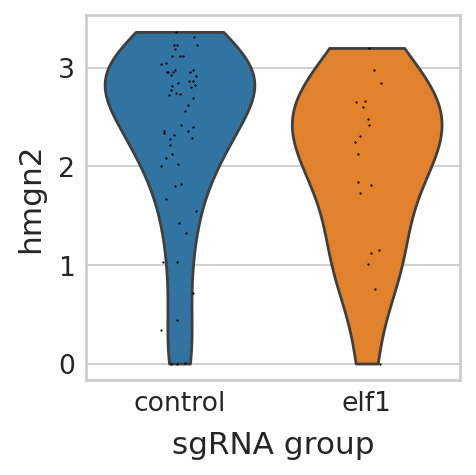

In [85]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['hmgn2'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'hmgn2_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

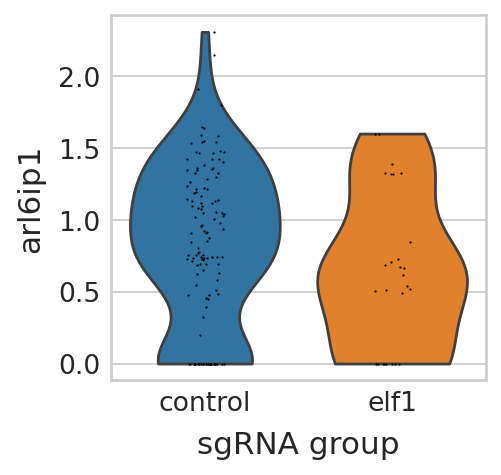

In [63]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['arl6ip1'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'arl6ip1_expression_elf1_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

## Visualize elf1 gene expression change when knockout tfec and fli1a

### knockout tfec

In [64]:
perturbseq = adata.copy()
perturbseq = perturbseq[~perturbseq.obs['cell_anno_new'].isin(["unclassified2","unclassified1","Mutant_hox23","Mutant"]),]
seu_small = perturbseq[perturbseq.obs['sgRNA_group'].isin(['control', "tfec"]),]
genotype = seu_small.obs["sgRNA_group"].tolist()

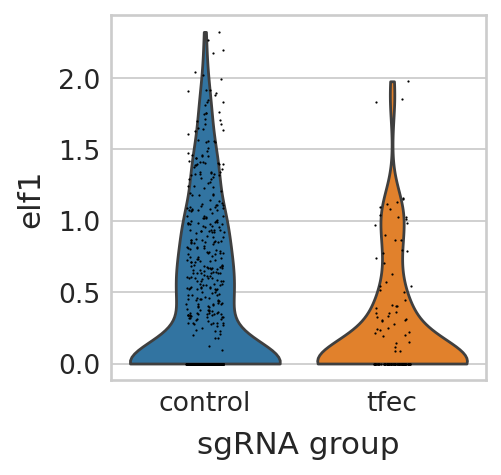

In [65]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['elf1'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'elf1_expression_tfec_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

### test significance

In [66]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "tfec","elf1"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "tfec","elf1"].X.toarray().reshape(-1),equal_var = False,alternative = "less")

TtestResult(statistic=-5.366020270431321, pvalue=8.610173685738961e-08, df=272.49193453818)

### knockout fli1a

In [67]:
perturbseq = adata.copy()
perturbseq = perturbseq[~perturbseq.obs['cell_anno_new'].isin(["unclassified2","unclassified1","Mutant_hox23","Mutant"]),]
seu_small = perturbseq[perturbseq.obs['sgRNA_group'].isin(['control', "fli1a"]),]
genotype = seu_small.obs["sgRNA_group"].tolist()

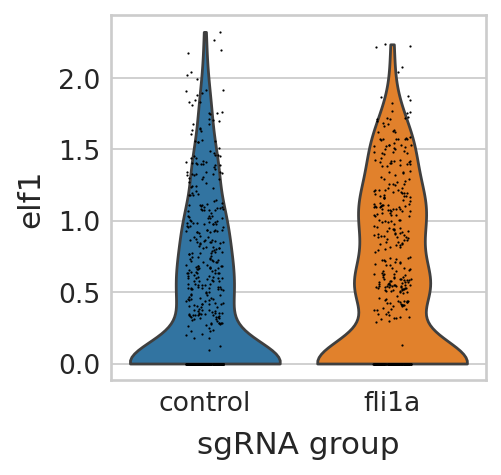

In [68]:
with mplscience.style_context():  # Use the mplscience style context
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    # Create the scatter plot
    sc.pl.violin(seu_small, ['elf1'], multi_panel=False,groupby="sgRNA_group",stripplot=True,ax=ax,show=False)
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'elf1_expression_fli1a_knockout.svg',
            format='svg',
            transparent=True,
            bbox_inches='tight'
        )

    # Display the plot
    plt.show()

## test significance

In [69]:
scipy.stats.ttest_ind(seu_small[np.array(genotype) == "fli1a","elf1"].X.toarray().reshape(-1),seu_small[np.array(genotype) != "fli1a","elf1"].X.toarray().reshape(-1),equal_var = False,alternative = "greater")

TtestResult(statistic=3.059975496268048, pvalue=0.0011362106276185085, df=1002.4934192631699)